In [1]:
##Loading the necessary packages 
import numpy as np
import cv2
from imutils.object_detection import non_max_suppression
import pytesseract
from matplotlib import pyplot as plt
import os
from PIL import Image

*You can download and use the EAST model from here https://github.com/ZER-0-NE/EAST-Detector-for-text-detection-using-OpenCV*

In [2]:
'''This class takes an image path as input, performs preprocessing, identifies the
grid, crops the grid, corrects perspective, writes all these stages to StagesImages folder'''

class ImagePreprocessor:

    '''Initializes the Class'''
    def __init__(self, imagepath):
        self.image = cv2.imread(imagepath, 0)
        self.imagePath = imagepath
        self.originalimage = np.copy(self.image)
        self.extractedgrid = None

    '''This function blurs the image, applies thresholding, inverts it and dilates the image'''
    def preprocess_image(self):
        gray = self.image
        #Applying Gaussian Blur to smooth out the noise
        gray = cv2.GaussianBlur(gray, (11, 11), 0)
        try:
            os.remove("../StagesImages/1.png")
        except:
            pass
        cv2.imwrite("../StagesImages/1.png", gray)

        # Applying thresholding using adaptive Gaussian|Mean thresholding
        gray = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C | cv2.ADAPTIVE_THRESH_GAUSSIAN_C,                     cv2.THRESH_BINARY, 5, 2)
        try:
            os.remove("../StagesImages/2.png")
        except:
            pass
        cv2.imwrite("../StagesImages/2.png", gray)

        #Inverting the image
        gray = cv2.bitwise_not(gray)
        try:
            os.remove("../StagesImages/3.png")
        except:
            pass
        cv2.imwrite("../StagesImages/3.png", gray)

        #Dilating the image to fill up the "cracks" in lines
        kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], np.uint8)
        gray = cv2.dilate(gray, kernel)
        self.image = gray
        try:
            os.remove("../StagesImages/4.png")
        except:
            pass
        cv2.imwrite("../StagesImages/4.png", gray)

    def image_smoothening(self):
        img = self.image
        ret1, th1 = cv2.threshold(img, cv2.THRESH_BINARY, 255, cv2.THRESH_BINARY)
        ret2, th2 = cv2.threshold(th1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        blur = cv2.GaussianBlur(th2, (5, 5), 0)
        ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        try:
            os.remove("../StagesImages/smooth.png")
        except:
            pass
        cv2.imwrite("../StagesImages/smooth.png", th3)

    # def set_image_dpi(self):
    #     im = Image.open(self.imagePath)
    #     length_x, width_y = im.size
    #     factor = min(1, float(1024.0 / length_x))
    #     size = int(factor * length_x), int(factor * width_y)
    #     im_resized = im.resize(size, Image.ANTIALIAS)
    #     im_resized.save('StagesImages/Improved_dpi.png', dpi=(300, 300))
        # try:
        #     os.remove("StagesImages/5.png")
        # except:
        #     pass
        # cv2.imwrite("StagesImages/5.png", im_resized)
        # return filename

In [25]:
preprocessor = ImagePreprocessor("/Users/inndata_flutter/Downloads/nrc_images/15.jpeg")
preprocessor.preprocess_image()
preprocessor.image_smoothening()

In [26]:
#Creating argument dictionary for the default arguments needed in the code. 
args = {"image":"../StagesImages/smooth.png", "east":"../datasets/frozen_east_text_detection.pb", "min_confidence":0.4, "width":320, "height":320}
#1216 768

### Loading EAST model

In [27]:
# load the pre-trained EAST model for text detection 
net = cv2.dnn.readNet(args["east"])

# We would like to get two outputs from the EAST model. 
#1. Probabilty scores for the region whether that contains text or not. 
#2. Geometry of the text -- Coordinates of the bounding box detecting a text
# The following two layer need to pulled from EAST model for achieving this. 
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

In [28]:
#Reading the image using opencv
image = cv2.imread(args['image'])

#Saving an original image and shape
orig = image.copy()
(origH, origW) = image.shape[:2]

# set the new height and width to default 320 by using args #dictionary.  
(newW, newH) = (args["width"], args["height"])

#Calculate the ratio between original and new image for both height and weight. 
#This ratio will be used to translate bounding box location on the original image. 
rW = origW / float(newW)
rH = origH / float(newH)

# resize the original image to new dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

# construct a blob from the image to forward pass it to EAST model
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)

In [29]:
#Forward pass the blob from the image to get the desired output layers
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

In [30]:
## Returns a bounding box and probability score if it is more than minimum confidence
def predictions(prob_score, geo):
	(numR, numC) = prob_score.shape[2:4]
	boxes = []
	confidence_val = []

	# loop over rows
	for y in range(0, numR):
		scoresData = prob_score[0, 0, y]
		x0 = geo[0, 0, y]
		x1 = geo[0, 1, y]
		x2 = geo[0, 2, y]
		x3 = geo[0, 3, y]
		anglesData = geo[0, 4, y]

		# loop over the number of columns
		for i in range(0, numC):
			if scoresData[i] < args["min_confidence"]:
				continue

			(offX, offY) = (i * 4.0, y * 4.0)

			# extracting the rotation angle for the prediction and computing the sine and cosine
			angle = anglesData[i]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# using the geo volume to get the dimensions of the bounding box
			h = x0[i] + x2[i]
			w = x1[i] + x3[i]

			# compute start and end for the text pred bbox
			endX = int(offX + (cos * x1[i]) + (sin * x2[i]))
			endY = int(offY - (sin * x1[i]) + (cos * x2[i]))
			startX = int(endX - w)
			startY = int(endY - h)

			boxes.append((startX, startY, endX, endY))
			confidence_val.append(scoresData[i])

	# return bounding boxes and associated confidence_val
	return (boxes, confidence_val)

In [31]:
# Find predictions and  apply non-maxima suppression
(boxes, confidence_val) = predictions(scores, geometry)
boxes = non_max_suppression(np.array(boxes), probs=confidence_val)

In [32]:
##Text Detection and Recognition 

# initialize the list of results
results = []

# loop over the bounding boxes to find the coordinate of bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the coordinates based on the respective ratios in order to reflect bounding box on the original image
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)

	#extract the region of interest
	r = orig[startY:endY, startX:endX]

	#configuration setting to convert image to string.  
	configuration = ("-l mya --oem 1 --psm 4")
    ##This will recognize the text from the image of bounding box
	text = pytesseract.image_to_string(r, config=configuration)

	# append bbox coordinate and associated text to the list of results 
	results.append(((startX, startY, endX, endY), text))



(၇.

စစ ၈ ၀၀၀. {၃၉၈၈ (စံ





(၉...



7



၈





င.

?1/ဘာသာ

4

ကြ.

စ္ဆ



(စ ၈.)



ဇ.)

ခ.

 

အာ

နားသည့်ဘပတ်တသား







မး ဂီ



တာ





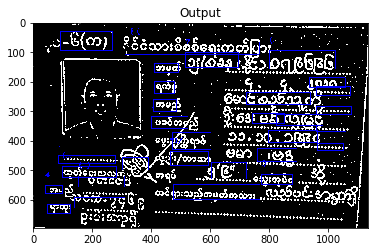

In [33]:
#Display the image with bounding box and recognized text
orig_image = orig.copy()

# Moving over the results and display on the image
for ((start_X, start_Y, end_X, end_Y), text) in results:
	# display the text detected by Tesseract
	print("{}\n".format(text))

	# Displaying text
	text = "".join([x if ord(x) < 128 else "" for x in text]).strip()
	cv2.rectangle(orig_image, (start_X, start_Y), (end_X, end_Y),
		(0, 0, 255), 2)
	cv2.putText(orig_image, text, (start_X, start_Y - 30),
		cv2.FONT_HERSHEY_COMPLEX, 0.7,(0,0, 255), 2)

plt.imshow(orig_image)
plt.title('Output')
plt.show()